# MPI for Sonar simulation

## Imports

In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')

In [2]:
%%px --no-stream --group-outputs=engine
%matplotlib inline
from mpi4py import MPI
import sys
import os
import tqdm

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, os.path.abspath("../cli/"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    positions_line,
    positions_half_circle,
    calculate_coordinates_from_pos,
)
from simulation.plotting import plot_velocity
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)
configuration['log-level'] = 'DEBUG'
configuration['language'] = 'openmp'
configuration['mpi'] = True

## Beamforming

In [3]:
%%px --no-stream --group-outputs=engine

v_env = 1.5
domain_size = (6, 6)
f0 = 5
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        FlatBottom(),
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Operator `initdamp` generated in 0.62 s
  * lowering.IET: 0.26 s (42.4 %)
     * specializing.IET: 0.18 s (29.3 %)
  * lowering.Clusters: 0.24 s (39.1 %)
     * specializing.Clusters: 0.14 s (22.8 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid1000/930420fc03435331fe81ae44cbe9e0de7df71370.c` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.16, 0.02 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<25> ran in 0.01 s [OI=0.88, 0.01 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<25,110> ran in 0.01 s [OI=0.69, 0.29 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<25> ran in 0.01 s [OI=0.88, 0.01 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<25,110> ran in 0.01 s [OI=0.69, 0.34 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<25> ran in 0.01 s [OI=0.88, 0.01 GFlops/s, 0.00 GPts/s]
  * section5[rank1]<25> ran in 0.01 s [OI=0.

In [4]:
%%px --no-stream --group-outputs=engine

ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src_args = {
    a: {
    "name": "src",
    "grid": sonars[a].model.grid,
    "npoint": ns,
    "f0": f0,
    "time_range": sonars[a].time_range,
    "coordinates": src_coord,
    }  
    for a in angles 
}

rec_args = {
    a: {
    "name": "rec",
    "grid": sonars[a].model.grid,
    "time_range": sonars[a].time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
    }
    for a in angles
}

In [5]:
%%px --no-stream --group-outputs=engine

for a, s in sonars.items():
    s.set_source("GaborSource", src_args[a])
    s.set_receiver("Receiver", rec_args[a])
    s.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(2790, 64) [1 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.68 s
  * lowering.IET: 0.79 s (47.1 %)
     * specializing.IET: 0.64 s (38.2 %)
  * lowering.Clusters: 0.62 s (37.0 %)
     * specializing.Clusters: 0.35 s (20.9 %)
Flops reduction after symbolic optimization: [92 --> 52]
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(2790, 64) [1 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.68 s
  * lowering.Clusters: 0.73 s (43.7 %)
     * specializing.Clusters: 0.44 s (26.4 %)
  * lowering.IET: 0.68 s (40.7 %)
     * specializing.IET: 0.54 s (32.3 %)
Flops reduction after symbolic optimization: [92 --> 52]
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(2790, 64) [1 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` gene

In [6]:
%%px --no-stream --group-outputs=engine
print(
    f"The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m"
)
print(f"The time step is {sonars[45].model.critical_dt}")
print(f"fs: {1 / sonars[45].model.critical_dt}")
print(f"Spacing: {sonars[45].model.spacing_map}")
print(f"Time range: {sonars[45].time_range.num}")

[stdout:0] 
The computational grid has (110, 110) grid points and physical size of (10.9, 10.9) m
The time step is 0.005
fs: 200.0
Spacing: {h_x: 0.1, h_y: 0.1}
Time range: 2790
[stdout:1] 
The computational grid has (110, 110) grid points and physical size of (10.9, 10.9) m
The time step is 0.005
fs: 200.0
Spacing: {h_x: 0.1, h_y: 0.1}
Time range: 2790


[output:0]

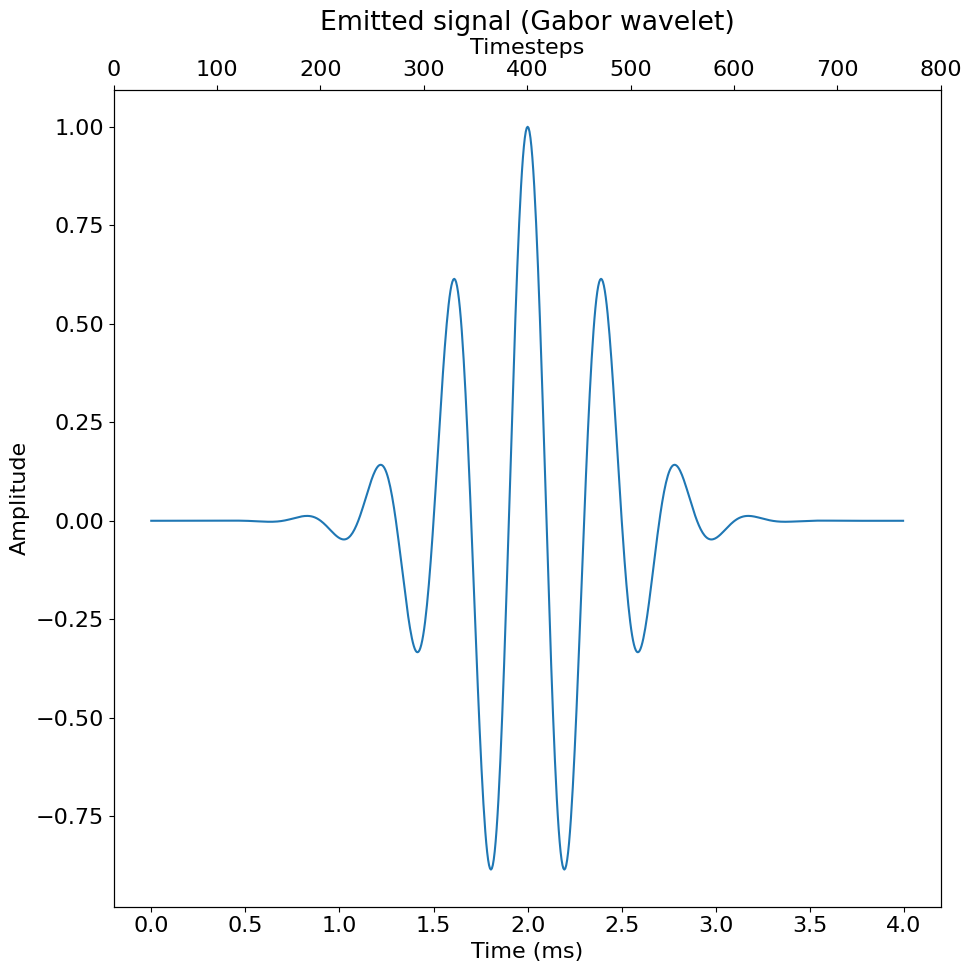

[output:1]

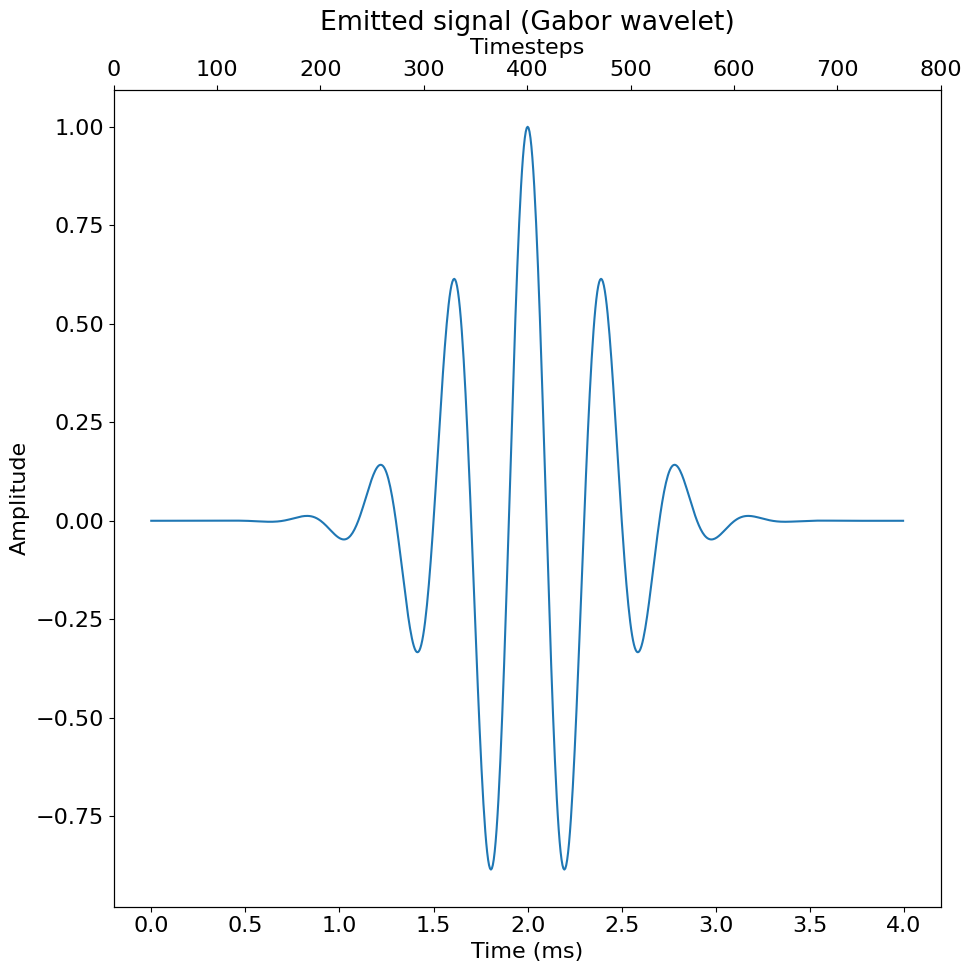

In [7]:
%%px --no-stream --group-outputs=engine

# plot_velocity(
#     sonars[45].model,
#     source=sonars[45].src.coordinates.data,
#     receiver=sonars[45].rec.coordinates.data,
# )

plt.figure()
plt.plot(sonars[45].src.time_values[:800], sonars[45].src.signal_packet)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel("Timesteps")
plt.title("Emitted signal (Gabor wavelet)")
plt.tight_layout()
plt.show()

In [8]:
%%px --no-stream --group-outputs=engine

recordings = {}
for a, s in sonars.items():
    s.run_beam(a)
    recordings[a] = s.rec.data

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
Simulation took 13.303301811218262 seconds
Simulation took 12.954939842224121 seconds
Simulation took 12.854378700256348 seconds
Simulation took 12.874874353408813 seconds
Simulation took 13.28662657737732 seconds
Simulation took 13.06608533859253 seconds
Simulation took 12.867835760116577 seconds
[stdout:1] 
mpicc -march=native -O3 -g -fPIC -Wall -std=c99 -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /tmp/devito-jitcache-uid1000/585189bcdb8cff1c7e575d470d76db8ec75012b4.c -lm -o /tmp/devito-jitcache-uid1000/585189bcdb8cff1c7e575d470d76db8ec75012b4.so
Simulation took 13.302324056625366 seconds
Simulation took 12.956103563308716 seconds
Simulation took 12.853801488876343 seconds
Simulation took 12.875547885894775 seconds
Simulation took 13.288863897323608 seconds
Simulation took 13.064552545547485 seconds
Simulation took 12.866711854934692 seconds


[stderr:0] 
Allocating host memory for u(3, 71, 126) [210 KB]
Allocating host memory for rec(2790, 90) [2 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/585189bcdb8cff1c7e575d470d76db8ec75012b4.c` in 0.44 s from jit-cache
Operator `Kernel` ran in 12.78 s
Global performance: [OI=1.09, 0.11 GFlops/s, 0.01 GPts/s]
Local performance:
  * section0[rank0]<89> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<93> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<2788,55,110> ran in 7.82 s [OI=1.04, 0.08 GFlops/s, 0.01 GPts/s]
  * section1[rank1]<2788,55,110> ran in 0.80 s [OI=1.04, 0.79 GFlops/s, 0.03 GPts/s]
  * section2[rank0]<<2788,44,2,2>,<2788,44,2,2>> ran in 4.78 s [OI=3.00, 0.01 GFlops/s, 0.01 GPts/s]
  * section2[rank1]<<2788,128,2,2>,<2788,128,2,2>> ran in 11.83 s [OI=3.00, 0.01 GFlops/s, 0.01 GPts/s]
  * section3[rank0]<<2788,89>,<2788,89,2,2>> ran in 0.17 s [OI=0.66, 0.07 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<<2788,93>,<

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[output:0]

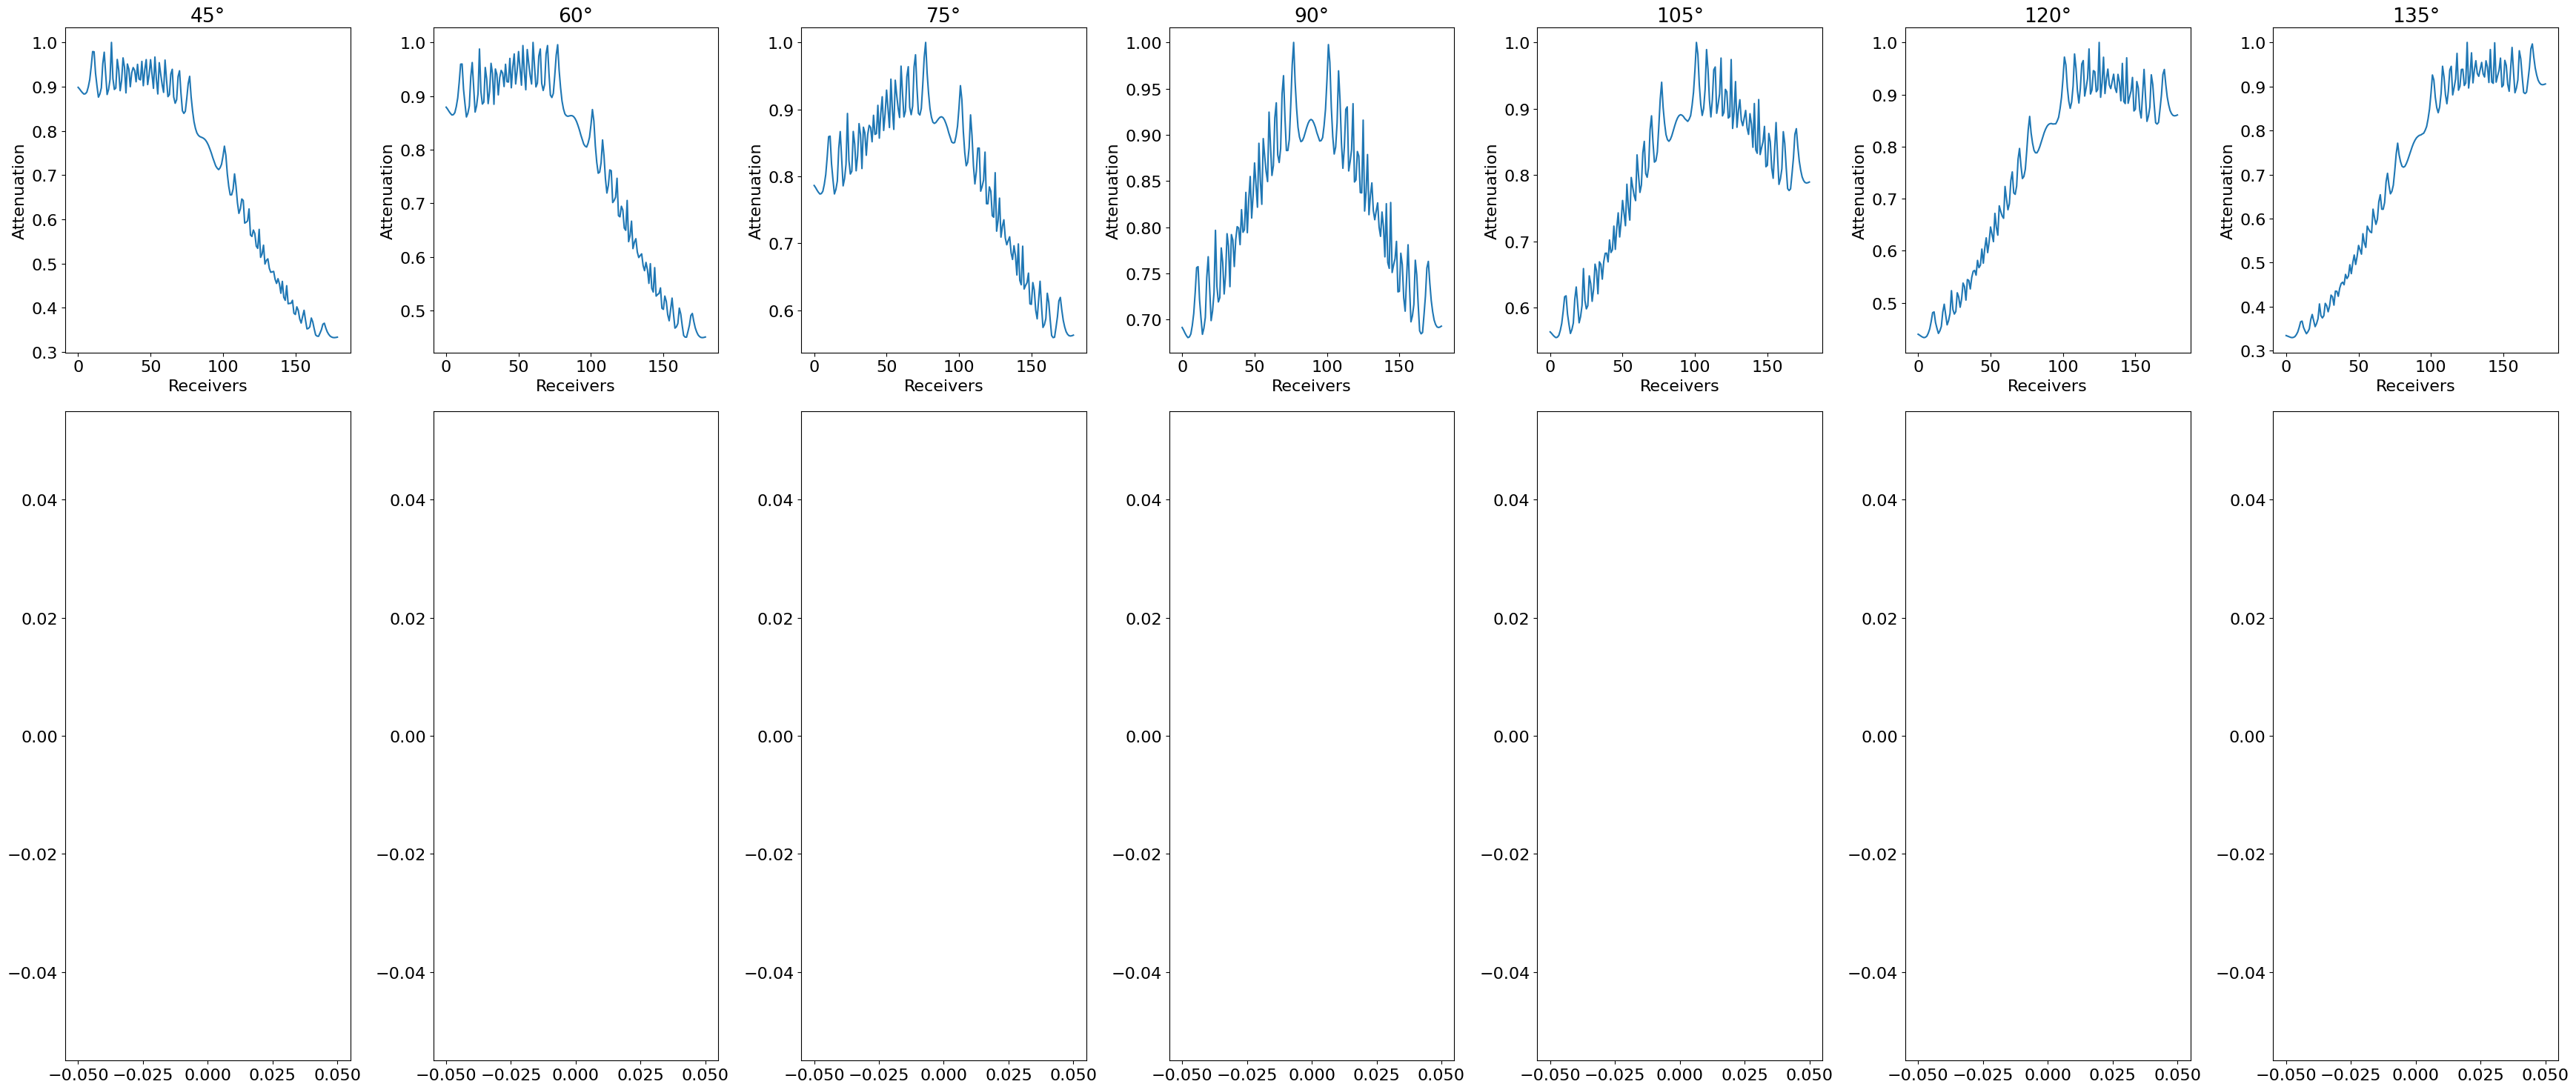

[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [13]:
%%px --no-stream --group-outputs=engine

comm = sonars[45].model.grid.distributor.comm
rank = sonars[45].model.grid.distributor.myrank

all_recordings = {a: comm.gather(val, root=0) for a, val in recordings.items()}
if rank == 0:
    all_recordings = {a: np.concatenate(val, axis=1) for a, val in all_recordings.items()}
    
    fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
    for i, (a, r) in enumerate(all_recordings.items()):
        recording = np.flip(r)
        ax[0, i].plot(
            np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
        )
        ax[0, i].set_xlabel("Receivers")
        ax[0, i].set_ylabel("Attenuation")
        ax[0, i].set_title(f"{a}°")
        ax[0, i].tick_params()

        ax[1, i].plot(r[40000:42000, 180 - a])
    fig.tight_layout()


## Detection with Correlation

In [ ]:
# %%px --no-stream --group-outputs=engine

# domain_size = (60, 30)
# radius = 28
# v_env = 1.5
# ns = 128
# source_distance = 0.002
# cy = (ns - 1) / 2 * source_distance + source_distance
# f0 = 50
# space_order = 8
# spatial_dist = round(v_env / f0 / 3, 6)
# dt = spatial_dist / 20

In [ ]:
# %%px --no-stream --group-outputs=engine

# sonar = Sonar(
#     domain_size,
#     f0,
#     v_env,
#     EllipsisBottom(True),
#     space_order=space_order,
#     dt=dt,
#     spatial_dist=spatial_dist,
# )
# sonar.set_source()
# sonar.set_receiver()
# sonar.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
51it [00:01, 25.50it/s]
Operator `initdamp` generated in 0.42 s
  * lowering.IET: 0.19 s (45.5 %)
     * specializing.IET: 0.14 s (33.5 %)
  * lowering.Clusters: 0.16 s (38.3 %)
     * specializing.Clusters: 0.10 s (23.9 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.14 s from jit-cache
Operator `initdamp` ran in 2.88 s
Global performance: [OI=0.22, 0.02 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,3508> ran in 0.01 s [OI=0.69, 392.06 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,3508> ran in 0.01 s [OI=0.69, 316.18 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  

In [ ]:
# %%px --no-stream --group-outputs=engine

# recording_45 = run_beam(
#     sonar.src,
#     sonar.rec,
#     sonar.op,
#     sonar.u,
#     sonar.source_distance,
#     sonar.time_range,
#     sonar.model.critical_dt,
#     45,
#     v_env,
# )

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
mpicxx -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp -lm -o /tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.so
Simulation took 66.77610564231873 seconds
[stdout:1] 
Simulation took 66.77397680282593 seconds


[stderr:0] 
Allocating host memory for u(3, 3270, 3524) [264 MB]
Allocating host memory for rec(123139, 64) [60 MB]
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp` in 2.49 s with `NvidiaCompiler`
Operator `Kernel` ran in 63.47 s
Global performance: [OI=1.28, 1816.06 GFlops/s, 44.30 GPts/s]
Local performance:
  * section0[rank0]<64> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<69> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<123137,3254,3508> ran in 60.66 s [OI=1.28, 950.10 GFlops/s, 23.18 GPts/s]
  * section1[rank1]<123137,3254,3508> ran in 60.71 s [OI=1.28, 949.28 GFlops/s, 23.16 GPts/s]
  * section2[rank0]<<123137,64,2,2>,<123137,64,2,2>> ran in 1.37 s [OI=3.00, 1.40 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<123137,69,2,2>,<123137,69,2,2>> ran in 1.34 s [OI=3.00, 1.53 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<123137,64>,<123137,64,2,2>> ran in 1.34 s [OI=0.66, 0.2